## Generative Modelling for Controllable Audio Synthesis of Piano Performance
Code below loads the pre-trained models and generates style-transferred spectrograms.

### Load dataset

In [1]:
from dataset import MAESTRO
from torch.utils.data import Dataset, DataLoader
from model_nms_latent import *
from nnAudio import Spectrogram
import torch
from torch.distributions import kl_divergence
from torch import optim
from sklearn.metrics import accuracy_score
import json, os
import datetime
from tqdm import tqdm
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt

In [2]:
with open('nms_latent_config.json') as f:
    args = json.load(f)
model_path = 'params/' + os.listdir('params/')[-1]

In [3]:
train_s_ds = MAESTRO(path='/data/MAESTRO', groups=['train_s'], sequence_length=320000)
train_s_dl = DataLoader(train_s_ds, batch_size=args["batch_size"], shuffle=True, num_workers=0)
val_s_ds = MAESTRO(path='/data/MAESTRO', groups=['validation_s'], sequence_length=320000)
val_s_dl = DataLoader(val_s_ds, batch_size=args["batch_size"], shuffle=False, num_workers=0)
test_s_ds = MAESTRO(path='/data/MAESTRO', groups=['test_s'], sequence_length=320000)
test_s_dl = DataLoader(test_s_ds, batch_size=args["batch_size"], shuffle=False, num_workers=0)

Loading group test_s: 100%|██████████| 178/178 [00:03<00:00, 50.87it/s]


In [4]:
from trainer_nms_latent_dynamic import Normalizer
normalizer = Normalizer(mode="imagewise")

### Load model

In [5]:
# configurations of n_mels and hop_size

n_mels, hop_size, LENGTH = 80, 512, 625
# n_mels, hop_size, LENGTH = 128, 512, 625
# n_mels, hop_size, LENGTH = 128, 256, 1250

In [6]:
model = NMSLatentDisentangledDynamic(input_dims=n_mels, hidden_dims=args["hidden_dims"], 
                                    z_dims=args["z_dims"],
                                    n_component=2)
model.cuda()

# load model paths based on config (change the path to your trained model names)
if n_mels == 80 and hop_size == 512:
    print("Loading params/nms_dynamic_20200629-160856.pt...")
    model.load_state_dict(torch.load("params/nms_dynamic_20200629-160856.pt"))

elif n_mels == 128 and hop_size == 256:
    print("Loading params/nms_dynamic_20200630-160635_bs-64_nmel-128_hs-256_h-256_z-64.pt...")
    model.load_state_dict(torch.load("params/nms_dynamic_20200630-160635_bs-64_nmel-128_hs-256_h-256_z-64.pt"))

elif n_mels == 128 and hop_size == 512:
    print("Loading params/nms_dynamic_20200630-161105_bs-64_nmel-128_hs-512_h-256_z-64.pt...")
    model.load_state_dict(torch.load("params/nms_dynamic_20200630-161105_bs-64_nmel-128_hs-512_h-256_z-64.pt"))

Loading params/nms_dynamic_20200629-160856.pt...


In [7]:
wav_to_melspec = Spectrogram.MelSpectrogram(sr=16000, n_mels=n_mels, hop_length=hop_size)

STFT filter created, time used = 0.0024 seconds
Mel filter created, time used = 0.0025 seconds


### Experiments
Experiment on some samples in the test set.

In [8]:
# experiment on some samples in the test set
audio, onset_pr, frame_pr, label = test_s_ds[72]     # (b, 320000), (b, t=625, 88)
_, _, _, label2 = test_s_ds[83]     # (b, 320000), (b, t=625, 88)
pr_visualize = onset_pr + frame_pr

Audio(audio.cpu().detach().numpy(), rate=16000)

In [9]:
pr = onset_pr
melspec = torch.transpose(wav_to_melspec(audio), 1, 2)[:, :-1, :]   # (b, 625, 128)
melspec_original = wav_to_melspec(audio)

# super-resolute if necessary (for hop-size < 512)
melspec_steps = melspec.shape[1]

if pr.shape[0] < melspec_steps:     
    labels = (torch.repeat_interleave(labels[0], int(melspec_steps // pr.shape[0]), dim=-1),
            torch.repeat_interleave(labels[1], int(melspec_steps // pr.shape[0]), dim=-1))
    pr = torch.repeat_interleave(pr, int(melspec_steps // pr.shape[0]), dim=0)
    
    # mask repeat values for onset pr
    mask = torch.zeros_like(pr)
    for j in range(mask.shape[0]):
        if j % int(melspec_steps // pr.shape[0]) == 0:
            mask[j, :] = 1
        else:
            mask[j, :] = 0
    pr = pr * mask

# use log melspec
pr = pr.cuda().unsqueeze(0)
melspec = normalizer.transform(torch.log(melspec + 1e-12)).cuda()

melspec_hat, z_art_lst, art_cls_lst, mu_art_lst, var_art_lst, \
                    z_dyn_lst, dyn_cls_lst, mu_dyn_lst, var_dyn_lst = model(melspec, pr)

melspec_hat_denorm = torch.exp(melspec_hat * (10 + 20) - 20).T.squeeze()

# conditional generation
def repar(mu, stddev, sigma=1):
    eps = Normal(0, sigma).sample(sample_shape=stddev.size()).cuda()
    z = mu + stddev * eps  # reparameterization trick
    return z

Get mean vectors for articulation and dynamics mixture components.

In [10]:
model.eval()
mu_art_0, var_art_0 = model.mu_art_lookup(torch.Tensor([0]).long().cuda()), model.logvar_art_lookup(torch.Tensor([0]).long().cuda()).exp_()
mu_art_1, var_art_1 = model.mu_art_lookup(torch.Tensor([1]).long().cuda()), model.logvar_art_lookup(torch.Tensor([1]).long().cuda()).exp_()
mu_dyn_0, var_dyn_0 = model.mu_dyn_lookup(torch.Tensor([0]).long().cuda()), model.logvar_dyn_lookup(torch.Tensor([0]).long().cuda()).exp_()
mu_dyn_1, var_dyn_1 = model.mu_dyn_lookup(torch.Tensor([1]).long().cuda()), model.logvar_dyn_lookup(torch.Tensor([1]).long().cuda()).exp_()

### Visualize spectrograms
Construct the spectrogram for gradual style morphing cases.

staccato soft -> legato loud


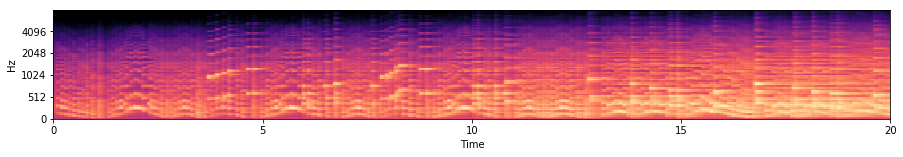

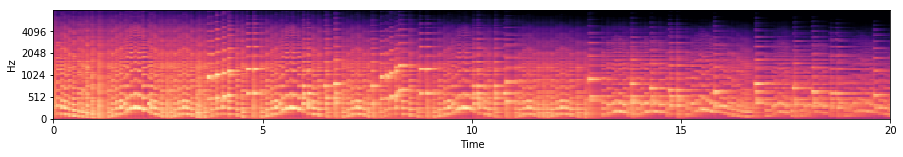

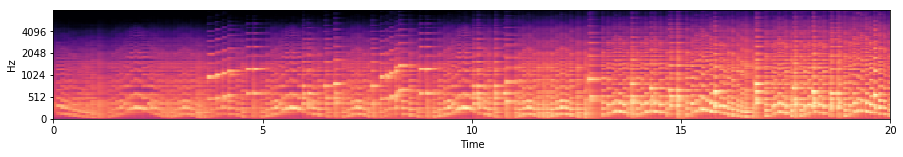

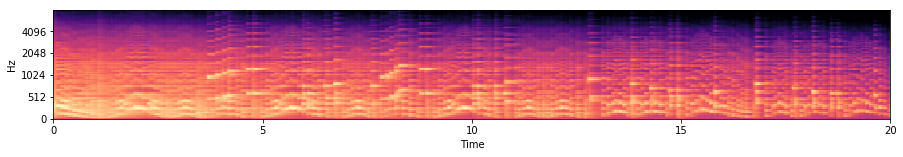

In [15]:
style_vector_lst = [
    [(mu_art_0, mu_art_1), (mu_dyn_0, mu_dyn_1)],  # staccato soft -> legato loud
    [(mu_art_0, mu_art_1), (mu_dyn_1, mu_dyn_0)],  # staccato loud -> legato soft
    [(mu_art_1, mu_art_0), (mu_dyn_0, mu_dyn_1)],  # legato soft -> staccato loud
    [(mu_art_1, mu_art_0), (mu_dyn_1, mu_dyn_0)],  # legato loud -> staccato soft
]

for idx, style_vector in enumerate(style_vector_lst):
    z_art_lst = []
    z_dyn_lst = []
    for i in range(LENGTH):
        art_src, art_tgt = style_vector[0]
        dyn_src, dyn_tgt = style_vector[1]

        # style morphing through time
        z_art_cur = art_src + (art_tgt - art_src) * (i / LENGTH)
        z_art_lst.append(z_art_cur)

        z_dyn_cur = dyn_src + (dyn_tgt - dyn_src) * (i / LENGTH)
        z_dyn_lst.append(z_dyn_cur)

    z_art_lst = torch.stack(z_art_lst, dim=1)
    z_dyn_lst = torch.stack(z_dyn_lst, dim=1)

    z_distribute = torch.cat([z_art_lst, z_dyn_lst], dim=-1)
    decoder_features = torch.cat([pr, z_distribute], dim=-1)
    x_hat = model.bilstm(decoder_features)[0]
    x_hat = torch.transpose(x_hat, 1,2)
    x_hat = x_hat.unsqueeze(-1)
    x_hat = nn.ReLU()(model.out_conv(x_hat))
    x_hat = nn.Sigmoid()(model.out_conv_2(x_hat))
    x_hat = x_hat.squeeze(-1)
    x_hat_1 = torch.transpose(x_hat, 1,2)

    x_hat_out = (x_hat_1 * (10 + 20) - 20).T.squeeze()
    
    if idx == 0:
        print("staccato soft -> legato loud")
    elif idx == 0:
        print("staccato loud -> legato soft")
    elif idx == 0:
        print("legato soft -> staccato loud")
    elif idx == 0:
        print("legato loud -> staccato soft")
        
    plt.figure(figsize=(15,2))
    melspec_denorm = torch.exp(x_hat_out).squeeze()
    melspec_db = librosa.power_to_db(melspec_denorm.cpu().detach().numpy().squeeze(), ref=np.max)
    librosa.display.specshow(melspec_db, x_axis='time',
                             y_axis='mel', sr=16000,
                             fmax=8000)